### Particle Filter Implementation

In [179]:
##Import all necessary packages-------------------------------------------
import math 
from math import sin
from math import cos
from math import exp

import numpy as np
from numpy.linalg import inv
from numpy.linalg import det

import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Trajectory')

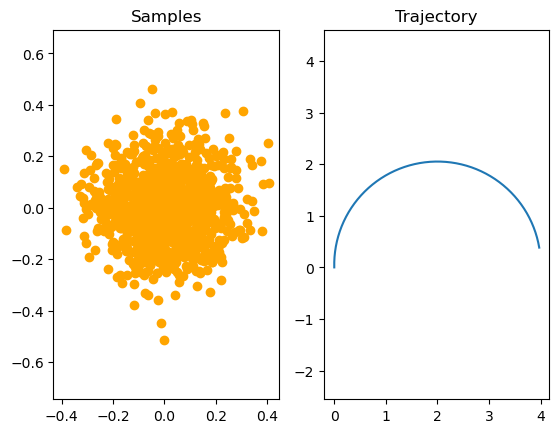

In [180]:
##Set up our inputs and constants-----------------------------------------------------------------------
tt = 6
time,dt = np.linspace(0, tt, math.ceil(tt/0.1), retstep=True)
variance = 0.02                 #variance
std = math.sqrt(variance)       #standard deviation


##We begin with a set of n samples ---------------------------------------------------------------------
#These samples are made to be a 2D normal distribution.
center  = np.array([0, 0, math.pi/2])    #Each integer describes the center of the column
std_arr = np.array([std, std, std])      #Each integer describes the standard deviation of the column
length  = 1000                            #Sample Number

samples = np.random.default_rng().normal(loc=center, scale=std_arr, size=(length, 3)).T
noise   = np.random.default_rng().normal(scale=std, size=(3, length))

#Generate the controls that we will be needing for the number of samples that we have. 
#Tranpose because the state and control vectors will be both need to be column vectors.
controls = np.array([[1, -0.5] for i in range(length)]).T

##Create the optimal trajectory that we will use for our z(t) vector.-----------------------------------
#Initialize our time step array with 5 state variables at each time step [x_1, x_2, theta, u_1, u_2 ...]
optimal = np.zeros(5*time.size)
optimal[0:5] = np.array([0,0,math.pi/2,1,-0.5])

#Create our reference trajectory -- make sure that it is scalable to larger sizes
for i in range(0,(len(optimal)-5),5):
    #Calculate the intial velocities.
    optimal[i + 5] = optimal[i] + dt * optimal[i + 3] * cos(optimal[i + 2])
    optimal[i + 6] = optimal[i + 1] + dt * optimal[i + 3] * sin(optimal[i + 2])
    optimal[i + 7] = optimal[i + 2] + dt * optimal[i + 4]
    optimal[i + 8] = optimal[i + 3]        
    optimal[i + 9] = optimal[i + 4]  

#Set the controls to 0 at the end.
optimal[-1], optimal[-2] = 0, 0

#Reshape our trajectory to be in the shape we want it to be. 
optimal = np.reshape(optimal,(time.size,5)).T 

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the intitial distribution
axs[0].scatter(samples[0,:], samples[1, :], c='orange')
axs[0].axis("equal")
axs[0].set_title("Samples")

axs[1].plot(optimal[0, :],optimal[1, :])
axs[1].axis("equal")
axs[1].set_title("Trajectory")

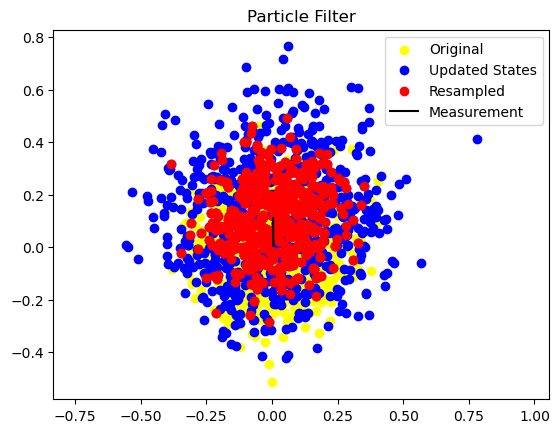

In [181]:
##Particle Filter Algorithm ----------------------------------------------------------------------------

#Samples to update.
update = np.copy(samples)

#Path to follow
path = np.ndarray((3,length))
path[:,0] = np.mean(update, axis=1)

#Create our axis and figure. Plot our initial samples since it won't be replotted. 
fig, axs = plt.subplots()
axs.scatter(samples[0,:], samples[1, :], color='yellow', label='Original')
axs.axis("equal")
axs.set_title("Particle Filter")

#Timestep of our actual process -- eventually we will loop through all the timesteps.
t = 0

#The measurement being taken is the actual position of the robot with some Gaussian distribution being taken around it. 
#The location is going to be at the "ideal location" surrounded by a Gaussian distribution.
z = np.random.default_rng().normal(loc=optimal[0:3,t+1], scale=std_arr, size=(length, 3)).T
path[:,t+1] 

#Find the covariance and mean matrix of our measurement model. Keep it as a column.
mu = np.mean(z, axis=1).reshape(3,1)
covar = np.cov(z, rowvar=True)          #Observations are across rows and variables are in columns.

#Update our path
path[:,t+1] = np.mean(z, axis=1)

#Initialize our p(zt|xt) array for the weights.
a = np.ndarray([length])

for i in range(length):  #Loop over all of our samples.
    #Prediction Step
    #Factor in state dynamics. Don't forget to add noise from the sampled noise. This tells us what each point will produce
    update[:, i] = noise[:, i] + update[:, i] + dt * np.array([[cos(update[2, i]) * controls[0, i]],
                                                               [sin(update[2, i]) * controls[0, i]],
                                                               [                    controls[1, i]]]).flatten()
    
    xt = update[:, i, None] 
    
    #Measurement Model. This will calculate the p(zt|xt) for all the points. 
    a[i] = (2 * math.pi)**(-3/2) * det(covar)**-0.5 * exp(-0.5 * (mu - xt).T @ inv(covar) @ (mu - xt))
    

#Normalize the vector so that the sum of the weights equals 1
norm_a = a/sum(a)

#Plot the updated array
axs.scatter(update[0,:], update[1, :], color='blue', label='Updated States')

#Initialize the new particle array. 
new_particle = np.ndarray((3,length))

##Resampling Algortithm
for ii in range(length):
    #Generate a random number from a uniform distribution
    randNum = np.random.uniform()

    #Find the index of the smallest cumulative sum greater than the random number. 
    index = 0
    weight_sum = 0

    for j in norm_a: #Iterate over our weight list
        weight_sum += j

        #Exit the loop if we meet the criterion.
        if weight_sum >= randNum:
            break

        #Update our particle index if we don't break out.
        index += 1

    #If we break out of the loop, add the particle to the new set. 
    new_particle[:,ii] = update[:,index]

#Plot the resampled
axs.scatter(new_particle[0,:], new_particle[1, :], color='red', label='Resampled')
axs.plot(path[0,0:2], path[1,0:2], color='black', label="Measurement")
axs.legend()

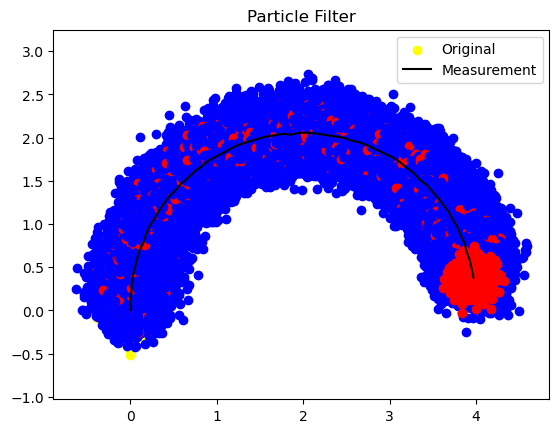

In [182]:
##Particle Filter Algorithm ----------------------------------------------------------------------------
#Samples to update.
update = np.copy(samples)

#Path to follow
path = np.ndarray((3,time.size))
path[:,0] = np.mean(update, axis=1)

#Create our axis and figure. Plot our initial since it won't be replotted. 
fig, axs = plt.subplots()
axs.scatter(samples[0,:], samples[1, :], color='yellow', label='Original')
axs.axis("equal")
axs.set_title("Particle Filter")

#Iterate over the timesteps-1
for jj in range(time.size-1):
    #The measurement being taken is the actual position of the robot with some Gaussian distribution being taken around it. 
    #The location is going to be at the "ideal location" surrounded by a Gaussian distribution.
    z = np.random.default_rng().normal(loc=optimal[0:3,jj+1], scale=std_arr, size=(length, 3)).T
    path[:,jj+1] 

    #Find the covariance and mean matrix of our measurement model. Keep it as a column.
    mu = np.mean(z, axis=1).reshape(3,1)
    covar = np.cov(z, rowvar=True)     #Observations are across rows and variables are in columns.

    #Update our path
    path[:,jj+1] = np.mean(z, axis=1)

    #Initialize our p(zt|xt) array for the weights.
    a = np.ndarray([length])

    for i in range(length):  #Loop over all of our samples.
        #Prediction Step
        #Factor in state dynamics. Don't forget to add noise from the sampled noise. This tells us what each point will produce
        update[:, i] = noise[:, i] + update[:, i] + dt * np.array([[cos(update[2, i]) * controls[0, i]],
                                                                   [sin(update[2, i]) * controls[0, i]],
                                                                   [                    controls[1, i]]]).flatten()
         
        xt = update[:, i, None] 
        
        #Measurement Model. This will calculate the p(zt|xt) for all the points.
        #This is the Multivariate Guassian PDF.
        a[i] = (2 * math.pi)**(-3/2) * det(covar)**-0.5 * exp(-0.5 * (mu - xt).T @ inv(covar) @ (mu - xt))

    #Normalize the vector so that the sum of the weights equals 1
    norm_a = a/sum(a)

    #Plot the updated array
    axs.scatter(update[0,:], update[1, :], color='blue')

    #Initialize the new particle array. 
    new_particle = np.ndarray((3,length))

    ##Resampling Algortithm
    for ii in range(length):
        #Generate a random number from a uniform distribution
        randNum = np.random.uniform()

        #Find the index of the smallest cumulative sum of weights greater than the random number. 
        index = 0
        weight_sum = 0

        for j in norm_a: #Iterate over our weight list
            weight_sum += j

            #Exit the loop if we meet the criterion.
            if weight_sum >= randNum:
                break

            #Update our particle index if we don't break out.
            index += 1

        #If we break out of the loop, add the particle to the new set. 
        new_particle[:,ii] = update[:,index]

    #Plot the resampled
    axs.scatter(new_particle[0,:], new_particle[1, :], color='red')

    #Set the update resamples to be the update samples for the next iterate.
    update = np.copy(new_particle)
        
axs.plot(path[0,:], path[1,:], color='black', label="Measurement")
axs.legend()

### Kalman Filter Implementation